<a href="https://colab.research.google.com/github/CelineHo03/Mental-Health-Exploring/blob/main/Mental_Health_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from scipy.special import logit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
import seaborn as sns
import warnings
import pickle
import shutil
import json
import os
import gc

In [7]:
from google.colab import drive

In [8]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [9]:
class CFG:
    train_path = '/content/drive/MyDrive/Mental Health Data/train.csv'
    test_path = '/content/drive/MyDrive/Mental Health Data/test.csv'
    sample_sub_path = '/content/drive/MyDrive/Mental Health Data/sample_submission.csv'
    original_data_path = '/Users/celineho/Downloads/final_depression_dataset_1.csv'
    target = 'Depression'
    n_folds = 5
    seed = 42

In [10]:
_train = pd.read_csv(CFG.train_path, index_col='id')
_test = pd.read_csv(CFG.test_path, index_col='id')
_sample_sub = pd.read_csv(CFG.sample_sub_path)

In [11]:
_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float64
 7   Work Pressure                          112782 non-null  float64
 8   CGPA                                   27898 non-null   float64
 9   Study Satisfaction                     27897 non-null   float64
 10  Job Satisfaction                       112790 non-null  float

**Analyze unique values in categorical columns¶**

In [14]:
cat_cols = _train.select_dtypes(include='object').columns.tolist()
num_cols = _train.select_dtypes(include=['float64', 'int64']).columns.tolist()


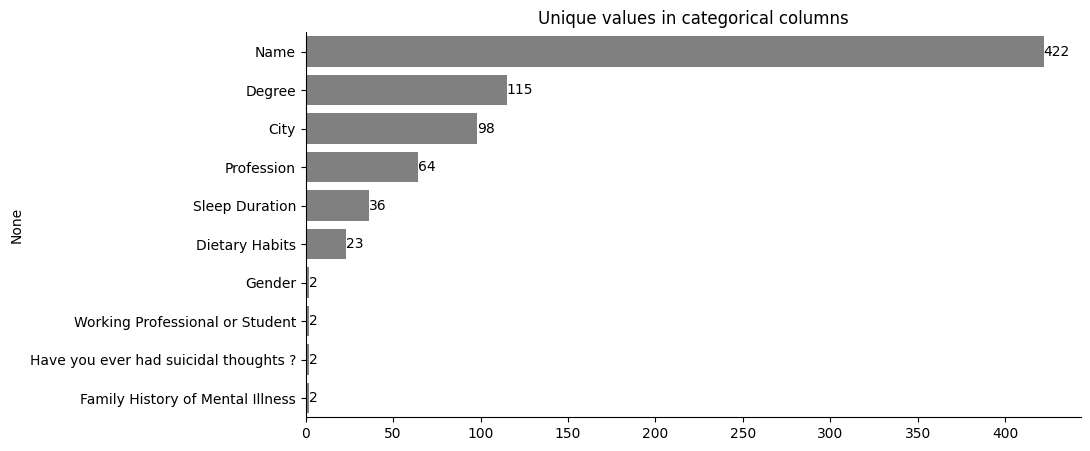

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.barplot(
    x=_train[cat_cols].nunique().sort_values(ascending=False).values,
    y=_train[cat_cols].nunique().sort_values(ascending=False).index,
    ax=ax,
    color="grey"
)
ax.set_title('Unique values in categorical columns')

for i, value in enumerate(_train[cat_cols].nunique().sort_values(ascending=False).values):
    ax.text(value, i, f'{value}', va='center')

sns.despine()
plt.show()


In [16]:
print(_train['City'].unique())
print(_test['City'].unique())

['Ludhiana' 'Varanasi' 'Visakhapatnam' 'Mumbai' 'Kanpur' 'Ahmedabad'
 'Thane' 'Nashik' 'Bangalore' 'Patna' 'Rajkot' 'Jaipur' 'Pune' 'Lucknow'
 'Meerut' 'Agra' 'Surat' 'Faridabad' 'Hyderabad' 'Srinagar' 'Ghaziabad'
 'Kolkata' 'Chennai' 'Kalyan' 'Nagpur' 'Vadodara' 'Vasai-Virar' 'Delhi'
 'Bhopal' 'Indore' 'Ishanabad' 'Vidhi' 'Ayush' 'Gurgaon' 'Krishna'
 'Aishwarya' 'Keshav' 'Harsha' 'Nalini' 'Aditya' 'Malyansh' 'Raghavendra'
 'Saanvi' 'M.Tech' 'Bhavna' 'Less Delhi' 'Nandini' 'M.Com' 'Plata'
 'Atharv' 'Pratyush' 'City' '3.0' 'Less than 5 Kalyan' 'MCA' 'Mira'
 'Moreadhyay' 'Morena' 'Ishkarsh' 'Kashk' 'Mihir' 'Vidya' 'Tolkata' 'Anvi'
 'Krinda' 'Ayansh' 'Shrey' 'Ivaan' 'Vaanya' 'Gaurav' 'Harsh' 'Reyansh'
 'Kashish' 'Kibara' 'Vaishnavi' 'Chhavi' 'Parth' 'Mahi' 'Tushar' 'MSc'
 'No' 'Rashi' 'ME' 'Molkata' 'Researcher' 'Kagan' 'Armaan' 'Ithal'
 'Nalyan' 'Dhruv' 'Galesabad' 'Itheg' 'Aaradhya' 'Pooja' 'Khushi'
 'Khaziabad' 'Jhanvi' 'Unirar']
['Visakhapatnam' 'Kolkata' 'Jaipur' 'Rajkot' 'Kalyan' 'M

In [17]:
_train['City'] = pd.Series(_train['City'])
_test['City'] = pd.Series(_test['City'])

# Define list of actual cities
city_list = ['Ludhiana', 'Varanasi', 'Visakhapatnam', 'Mumbai', 'Kanpur', 'Ahmedabad',
             'Thane', 'Nashik', 'Bangalore', 'Patna', 'Rajkot', 'Jaipur', 'Pune', 'Lucknow',
             'Meerut', 'Agra', 'Surat', 'Faridabad', 'Hyderabad', 'Srinagar', 'Ghaziabad',
             'Kolkata', 'Chennai', 'Kalyan', 'Nagpur', 'Vadodara', 'Vasai-Virar', 'Delhi',
             'Bhopal', 'Indore']

# Replace non-city values with NaN
def replace_non_cities(series):
    return series.apply(lambda x: x if x in city_list else np.NaN)

In [18]:
print(_train['Degree'].unique())
print(_test['Degree'].unique())

['BHM' 'LLB' 'B.Pharm' 'BBA' 'MCA' 'MD' 'BSc' 'ME' 'B.Arch' 'BCA' 'BE'
 'MA' 'B.Ed' 'B.Com' 'MBA' 'M.Com' 'MHM' 'BA' 'Class 12' 'M.Tech' 'PhD'
 'M.Ed' 'MSc' 'B.Tech' 'LLM' 'MBBS' 'M.Pharm' 'UX/UI Designer' 'MPA' 'BH'
 'Nalini' 'BEd' 'B.Sc' 'Veda' 'Bhopal' 'S.Tech' 'Degree' '20' 'Class 11'
 'H_Pharm' 'M' 'P.Com' 'BPharm' 'Business Analyst' 'M.Arch' 'LL.Com'
 'Data Scientist' 'MPharm' 'L.Ed' 'P.Pharm' 'Kalyan' 'Unite' 'BArch'
 'HR Manager' 'Badhya' 'S.Pharm' 'LLBA' 'Vrinda' 'M. Business Analyst'
 'Bhavesh' '0' 'LLCom' '29' 'MTech' 'Vivaan' 'BPA' 'Plumber' '5.61' 'Brit'
 'B.03' 'Ritik' '5.56' 'MEd' 'B' 'B BA' '7.06' 'B.B.Arch' 'ACA' 'Brithika'
 'CGPA' '24' 'M_Tech' 'Pihu' 'BB' 'Jhanvi' 'LLTech' 'Aarav' 'Entrepreneur'
 '8.56' 'LHM' 'Lata' 'S.Arch' 'Marsh' 'HCA' '5.88' 'B.Student' 'LL B.Ed'
 'M.S' 'Navya' 'Mahika' nan 'K.Ed' 'B.3.79' 'Mthanya'
 'Working Professional' 'Esha' 'LLS' 'LLEd' 'E.Tech' 'Doctor' 'N.Pharm'
 'LCA' 'B B.Com' 'RCA' 'Mihir' 'Advait']
['LLB' 'B.Ed' 'B.Arch' 'BSc' 'BCA' '

In [19]:
valid_degrees = ['BHM', 'LLB', 'B.Pharm', 'BBA', 'MCA', 'MD', 'BSc', 'ME', 'B.Arch', 'BCA', 'BE',
                 'MA', 'B.Ed', 'B.Com', 'MBA', 'M.Com', 'MHM', 'BA', 'M.Tech', 'PhD', 'M.Ed', 'MSc',
                 'B.Tech', 'LLM', 'MBBS', 'M.Pharm', 'M.Arch', 'M.S', 'BPA', 'BStudent', 'PCom', 'MTech']

# Replace non-degree values with NaN
def replace_non_degrees(series):
    return series.apply(lambda x: x if x in valid_degrees else np.NaN)

# Convert lists to pandas Series
_train['Degree'] = pd.Series(_train['Degree'])
_test['Degree'] = pd.Series(_test['Degree'])


# Apply the replacement function
_train['Degree'] = replace_non_degrees(_train['Degree'])
_test['Degree'] = replace_non_degrees(_test['Degree'])

In [20]:
print(_train['Profession'].unique())
print(_test['Profession'].unique())

['Chef' 'Teacher' nan 'Business Analyst' 'Finanancial Analyst' 'Chemist'
 'Electrician' 'Software Engineer' 'Data Scientist' 'Plumber'
 'Marketing Manager' 'Accountant' 'Entrepreneur' 'HR Manager'
 'UX/UI Designer' 'Content Writer' 'Educational Consultant'
 'Civil Engineer' 'Manager' 'Pharmacist' 'Financial Analyst' 'Architect'
 'Mechanical Engineer' 'Customer Support' 'Consultant' 'Judge'
 'Researcher' 'Pilot' 'Graphic Designer' 'Travel Consultant'
 'Digital Marketer' 'Lawyer' 'Research Analyst' 'Sales Executive' 'Doctor'
 'Unemployed' 'Investment Banker' 'Family Consultant' 'B.Com' 'BE'
 'Student' 'Yogesh' 'Dev' 'MBA' 'LLM' 'BCA' 'Academic' 'Profession'
 'FamilyVirar' 'City Manager' 'BBA' 'Medical Doctor'
 'Working Professional' 'MBBS' 'Patna' 'Unveil' 'B.Ed' 'Nagpur' 'Moderate'
 'M.Ed' 'Analyst' 'Pranav' 'Visakhapatnam' 'PhD' 'Yuvraj']
['Judge' 'Educational Consultant' 'Teacher' nan 'Customer Support'
 'Chemist' 'Content Writer' 'Consultant' 'HR Manager' 'Research Analyst'
 'Digital

In [21]:
valid_professions = ['Chef', 'Teacher', 'Business Analyst', 'Finanancial Analyst', 'Chemist',
                      'Electrician', 'Software Engineer', 'Data Scientist', 'Plumber',
                      'Marketing Manager', 'Accountant', 'Entrepreneur', 'HR Manager',
                      'UX/UI Designer', 'Content Writer', 'Educational Consultant',
                      'Civil Engineer', 'Manager', 'Pharmacist', 'Financial Analyst', 'Architect',
                      'Mechanical Engineer', 'Customer Support', 'Consultant', 'Judge',
                      'Researcher', 'Pilot', 'Graphic Designer', 'Travel Consultant',
                      'Digital Marketer', 'Lawyer', 'Research Analyst', 'Sales Executive', 'Doctor',
                      'Unemployed', 'Investment Banker', 'Family Consultant', 'Student',
                      'Working Professional', 'Medical Doctor', 'B.Com', 'BE', 'MBA', 'LLM', 'BCA']

# Replace non-profession values with NaN
def replace_non_professions(series):
    return series.apply(lambda x: x if x in valid_professions else np.nan)

# Apply the replacement function
_train['Profession'] = replace_non_professions(_train['Profession'])
_test['Profession'] = replace_non_professions(_test['Profession'])

In [22]:
print(_train['Dietary Habits'].unique())
print(_test['Dietary Habits'].unique())

['Healthy' 'Unhealthy' 'Moderate' 'Yes' 'Pratham' 'BSc' 'Gender' '3'
 'More Healthy' 'Less than Healthy' 'Mihir' '1.0' 'Hormonal' 'Electrician'
 nan 'No Healthy' 'Less Healthy' 'M.Tech' 'Vegas' 'No' 'Male' 'Indoor'
 'Class 12' '2']
['Moderate' 'Healthy' 'Unhealthy' 'More Healthy' 'No' 'Indoor' 'Prachi'
 nan 'Male' 'Less Healthy' 'Mealy' 'Resistant' 'MCA' '5 Healthy'
 'Academic' 'Educational' 'Soham' '5 Unhealthy' 'Vivaan' 'Raghav' '1.0'
 'Naina' 'Kolkata']


In [23]:
valid_dietary_habits = ['Healthy', 'Unhealthy', 'Moderate', 'More Healthy', 'Less Healthy']

# Replace non-dietary habit values with NaN
def replace_non_dietary_habits(series):
    return series.apply(lambda x: x if x in valid_dietary_habits else np.nan)

# Apply the replacement function
_train['Dietary Habits'] = replace_non_dietary_habits(_train['Dietary Habits'])
_test['Dietary Habits'] = replace_non_dietary_habits(_test['Dietary Habits'])

In [24]:
print(_train['Sleep Duration'].unique())
print(_test['Sleep Duration'].unique())

valid_sleep_durations = ['More than 8 hours', 'Less than 5 hours', '5-6 hours', '7-8 hours',
                         '1-2 hours', '6-8 hours', '4-6 hours', '6-7 hours', '10-11 hours',
                         '8-9 hours', '9-11 hours', '2-3 hours', '3-4 hours', '4-5 hours',
                         '1-3 hours', '3-6 hours', '9-5 hours', '9-6 hours', '60-65 hours',
                         '50-75 hours', '9-10 hours', '20-21 hours']

# Replace non-sleep duration values with NaN
def replace_non_sleep_durations(series):
    return series.apply(lambda x: x if x in valid_sleep_durations else np.nan)

# Apply the replacement function
_train['Sleep Duration'] = replace_non_sleep_durations(_train['Sleep Duration'])
_test['Sleep Duration'] = replace_non_sleep_durations(_test['Sleep Duration'])


['More than 8 hours' 'Less than 5 hours' '5-6 hours' '7-8 hours'
 'Sleep_Duration' '1-2 hours' '6-8 hours' '4-6 hours' '6-7 hours'
 '10-11 hours' '8-9 hours' '40-45 hours' '9-11 hours' '2-3 hours'
 '3-4 hours' 'Moderate' '55-66 hours' '4-5 hours' '9-6 hours' '1-3 hours'
 'Indore' '45' '1-6 hours' '35-36 hours' '8 hours' 'No' '10-6 hours'
 'than 5 hours' '49 hours' 'Unhealthy' 'Work_Study_Hours' '3-6 hours'
 '45-48 hours' '9-5' 'Pune' '9-5 hours']
['Less than 5 hours' '7-8 hours' 'More than 8 hours' '5-6 hours' '0'
 'Meerut' '9-5 hours' '6-7 hours' '60-65 hours' 'Vivan' '3-4 hours'
 '1-6 hours' '9-5' 'Unhealthy' '8-9 hours' '4-5 hours' 'than 5 hours'
 '9-6 hours' '1-2 hours' '8-89 hours'
 'Have_you_ever_had_suicidal_thoughts' '20-21 hours' '10-6 hours'
 '1-3 hours' '6 hours' '50-75 hours' '4-6 hours' '2-3 hours' '9-11 hours'
 '9-10 hours' '3-6 hours']


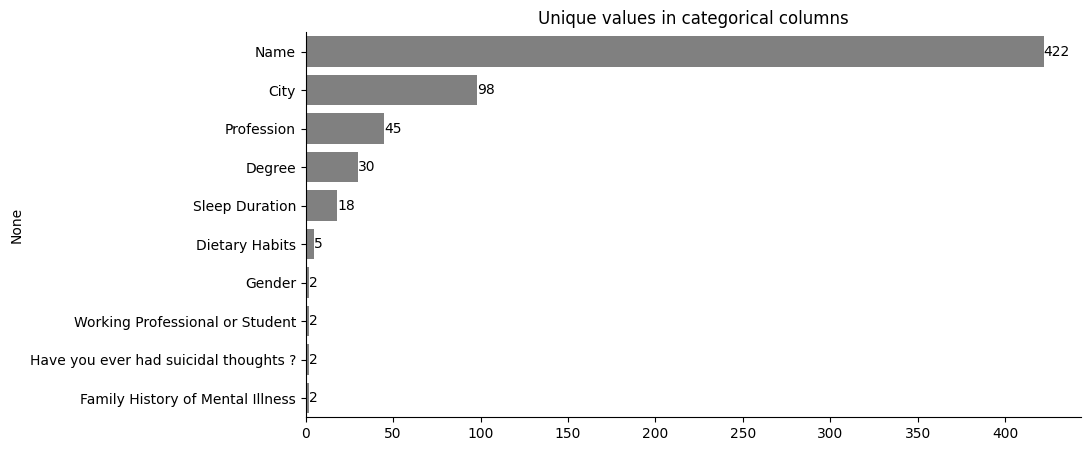

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.barplot(
    x=_train[cat_cols].nunique().sort_values(ascending=False).values,
    y=_train[cat_cols].nunique().sort_values(ascending=False).index,
    ax=ax,
    color="grey"
)
ax.set_title('Unique values in categorical columns')

for i, value in enumerate(_train[cat_cols].nunique().sort_values(ascending=False).values):
    ax.text(value, i, f'{value}', va='center')

sns.despine()
plt.show()


In [26]:
depression_counts = _train.Depression.value_counts(normalize = True).reset_index()
print(depression_counts)
depression_counts.columns = ['Depression', 'Proportion']

   Depression  proportion
0           0    0.818287
1           1    0.181713


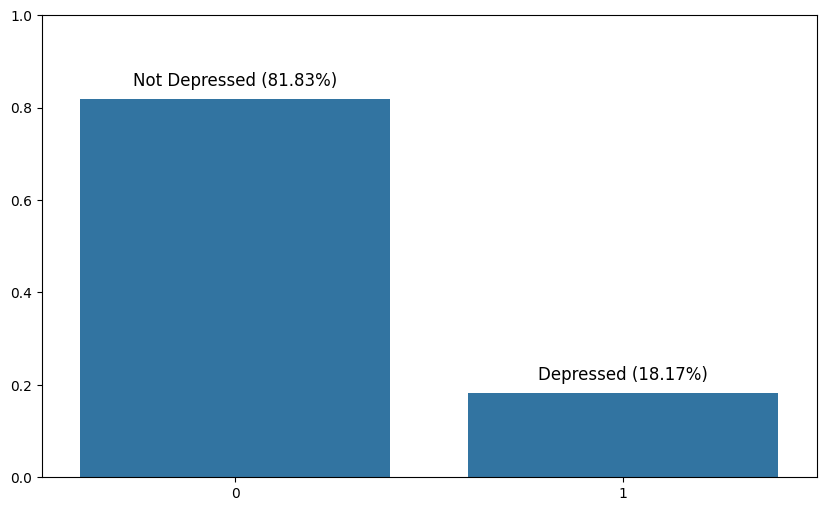

In [27]:
palette = {0: sns.color_palette("Set1")[1], 1: sns.color_palette("Set1")[0]}
class_mapping = {0: 'Not Depressed', 1:'Depressed'}
plt.figure(figsize=(10,6))
sns.barplot( x='Depression', y='Proportion', data=depression_counts)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.ylim(0,1) #limit y-axis values to the range [0,1]
for index, row in depression_counts.iterrows():
    plt.text(row.name, row.Proportion + 0.02, f'{class_mapping[row.name]} ({row.Proportion:.2%})', ha='center', va='bottom', fontsize = 12)

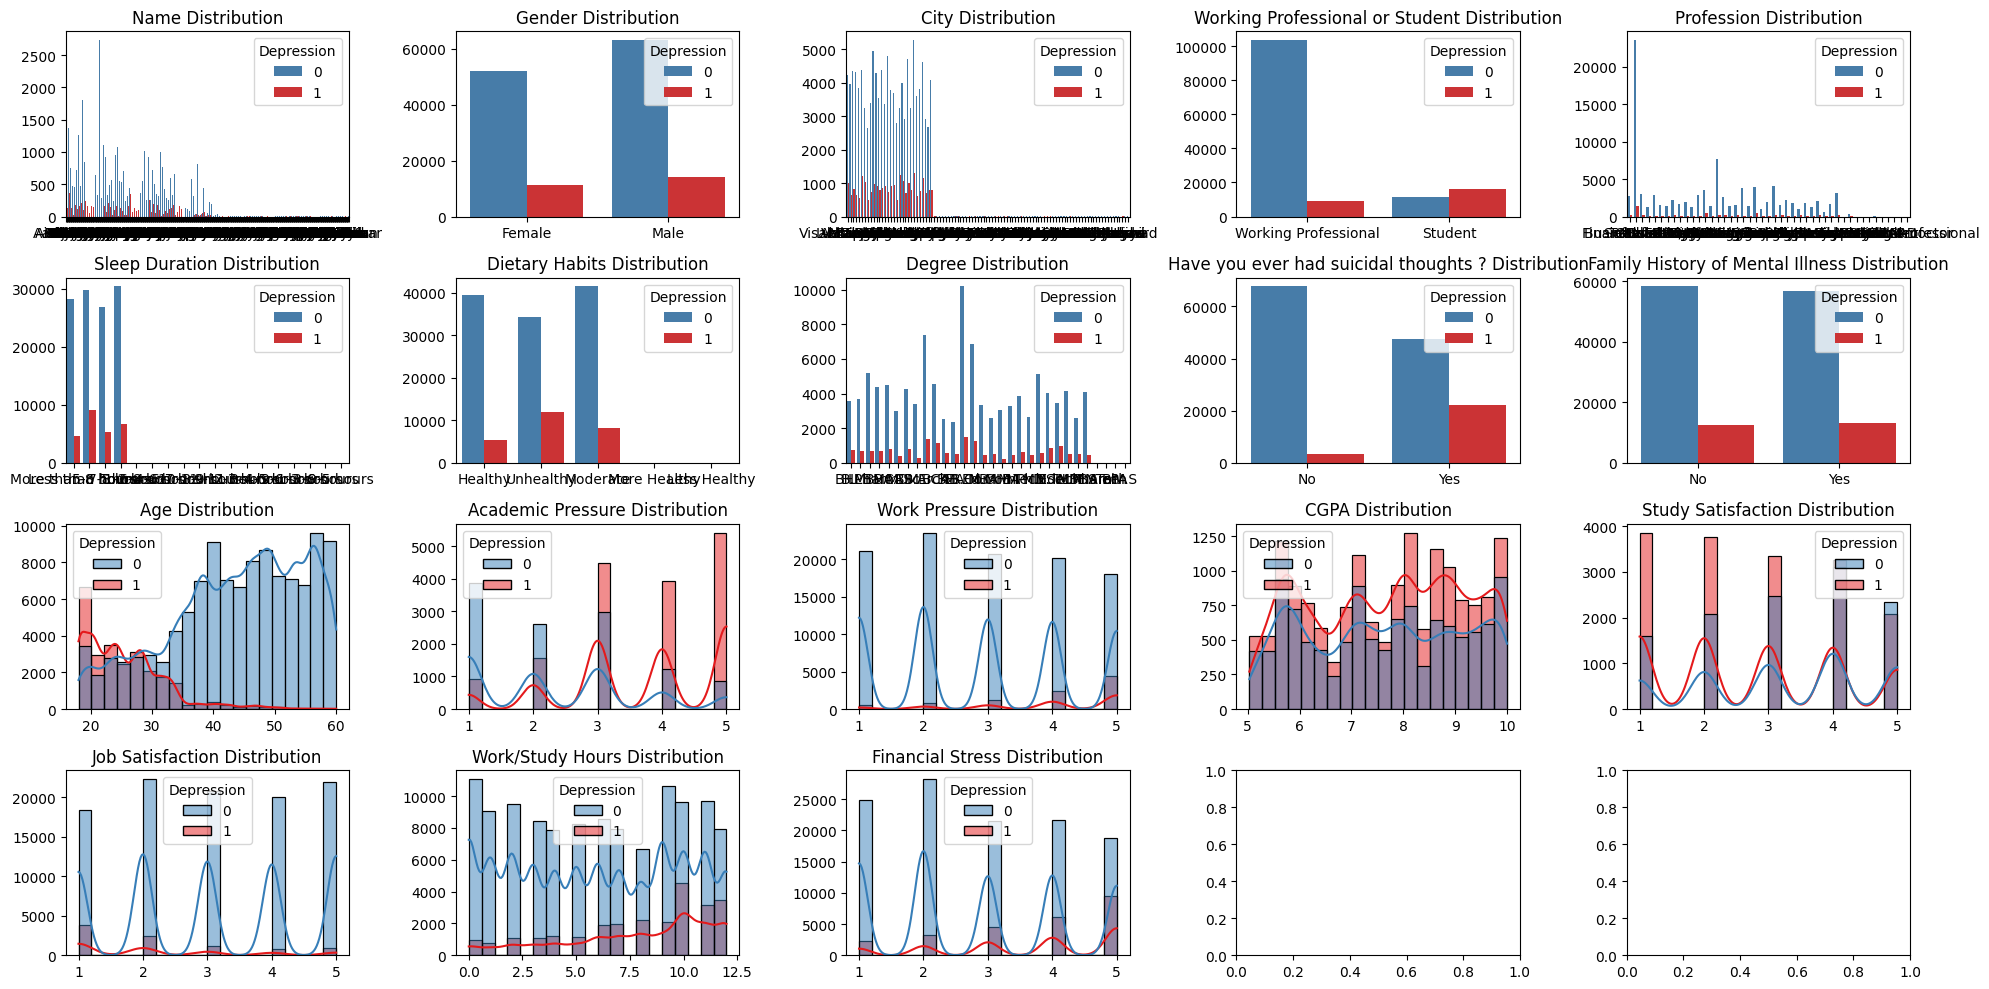

In [28]:

palette = {0: sns.color_palette("Set1")[1], 1: sns.color_palette("Set1")[0]}

# Visualize the distribution of each categorical and numeric variable, split by the target variable
fig, axes = plt.subplots(nrows=(len(cat_cols) + len(num_cols) + 4) // 5, ncols=5, figsize=(20, 10))
axes = axes.flatten()

# Plot for categorical variables
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=_train, hue=CFG.target, ax=axes[i], palette=palette)
    axes[i].set_title(f'{col} Distribution', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Plot for numeric variables
for i, col in enumerate(num_cols, start=len(cat_cols)):
    # Check if column exists in _train
    if col in _train.columns:
        # Use melt to reshape the data into long format
        long_data = pd.melt(_train, id_vars=[CFG.target], value_vars=[col],
                            var_name='Variable', value_name='Value')

        # Debugging check: Ensure long_data is not empty
        if not long_data.empty:
            # Check if there are enough unique values to plot KDE
            if long_data['Value'].nunique() > 1:
                sns.histplot(data=long_data, x='Value', hue=CFG.target, ax=axes[i], palette=palette, bins=20, kde=True)
            else:
                sns.histplot(data=long_data, x='Value', hue=CFG.target, ax=axes[i], palette=palette, bins=20)
            axes[i].set_title(f'{col} Distribution', fontsize=12)
            axes[i].set_xlabel('')
            axes[i].set_ylabel('')
        else:
            print(f"Warning: No data for column '{col}'")
    else:
        print(f"Warning: Column '{col}' not found in _train")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

**Check for missing values**

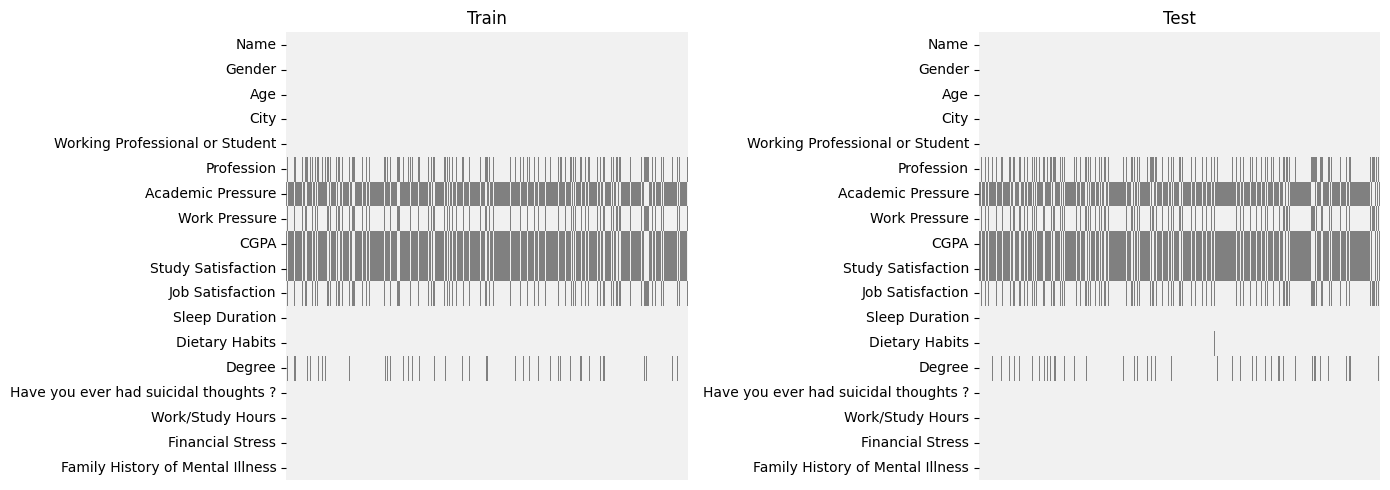

In [29]:
train_null_values  = _train.drop(columns=CFG.target).isnull().T
test_null_values = _test.isnull().T

# Check for missing values in the target variable

fig, axes = plt.subplots(1,2, figsize=(14,5))

sns.heatmap(train_null_values, cbar=False, ax=axes[0],
            cmap=sns.light_palette("grey", as_cmap=True))
axes[0].set_title('Train')
axes[0].set_xlabel('')
axes[0].set_xticks([])

sns.heatmap(test_null_values, cbar=False, ax=axes[1], cmap=sns.light_palette("grey", as_cmap=True))
axes[1].set_title('Test')
axes[1].set_xlabel('')
axes[1].set_xticks([])

plt.tight_layout()
plt.show()

In [ ]:
predictor.fit(
    train_data=_train,
    num_bag_folds=CFG.n_folds,
    presets='best_quality',
    time_limit=800
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.68 GB / 12.67 GB (68.5%)
Disk Space Avail:   74.44 GB / 107.72 GB (69.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

KeyboardInterrupt: 

In [1]:
leaderboard= predictor.leaderboard(silent=True)
print(leaderboard)

NameError: name 'predictor' is not defined

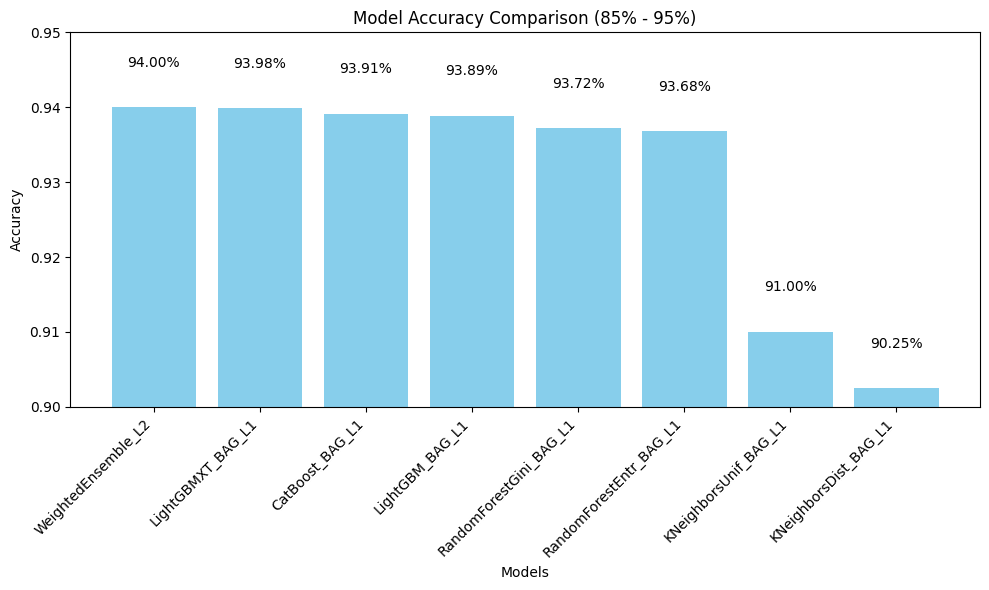

In [ ]:
# prompt: help me build plot to compare the accuracy of each model. I want to make difference in accuracy between each model is clearer, so x axis should only contain value from 85% to 95%.

import matplotlib.pyplot as plt
# Filter for accuracy between 85% and 95%
leaderboard_filtered = leaderboard[
    (leaderboard['score_val'] >= 0.85) & (leaderboard['score_val'] <= 0.95)
]


plt.figure(figsize=(10, 6))
plt.bar(leaderboard_filtered['model'], leaderboard_filtered['score_val'], color='skyblue')
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (85% - 95%)")
plt.ylim(0.90, 0.95)  # Set y-axis limits
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability

# Add accuracy values on top of each bar
for i, val in enumerate(leaderboard_filtered['score_val']):
    plt.text(i, val + 0.005, f"{val:.2%}", ha='center', va='bottom')


plt.tight_layout()
plt.show()

In [ ]:
y_pred = predictor.predict(_test)
y_true = _sample_sub[CFG.target]
test_performance = accuracy_score(y_true, y_pred)
print(f'Test Performance: {test_performance}')

Test Performance: 0.8247334754797442


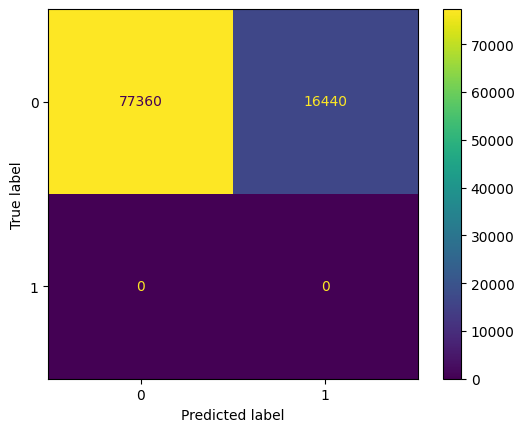

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


   Depression  proportion
0           0    0.818287
1           1    0.181713
